## Library imports

In [ ]:
##!pip install pickle5

In [1]:
# basic imports
import os
import gc
import sys
import math
import glob
import random
import itertools
import numpy as np
import pandas as pd
import pickle5 as pickle
from tqdm.notebook import tqdm
from scipy.spatial.transform import Rotation as R

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
## from  torch.cuda.amp import autocast, GradScaler

## for ESEKF imports
sys.path.append('ESEKF/')
from rotations import Quaternion, skew_symmetric

# metrics calculation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

# basic plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

import warnings  
warnings.filterwarnings('ignore')

## Config parameters

In [2]:
class CFG:
    # pipeline parameters
    SEED        = 42
    TRAIN       = True
    LR_FIND     = False
    TEST        = False
    N_FOLDS     = 5 
    N_EPOCHS    = 40
    TEST_BATCH_SIZE  = 128
    TRAIN_BATCH_SIZE = 32
    NUM_WORKERS      = 4
    DATA_FRAC        = 1.0
    FOLD_TO_TRAIN    = [0, 1, 2, 3, 4] # 

    # model parameters
    MODEL_ARCH  = 'CNN'
    MODEL_NAME  = 'CNN_v1'
    WGT_PATH    = ''
    WGT_MODEL   = ''
    PRINT_N_EPOCH = 2
    
    # scheduler variables
    MAX_LR    = 1e-2
    MIN_LR    = 1e-5
    SCHEDULER = 'CosineAnnealingWarmRestarts'  # ['ReduceLROnPlateau', 'None', 'OneCycleLR','CosineAnnealingLR']
    T_0       = 5      # CosineAnnealingWarmRestarts
    T_MULT    = 2      # CosineAnnealingWarmRestarts
    T_MAX     = 10     # CosineAnnealingLR

    # optimizer variables
    OPTIMIZER     = 'Adam'
    WEIGHT_DECAY  = 1e-6
    GRD_ACC_STEPS = 1
    MAX_GRD_NORM  = 2

    # features parameters
    USE_FREQ_FEATS = True
    USE_DT_FEATS   = True
    
    BUILDING_SITES_RANGE = [0,1]

In [3]:
floor_map = {"B2": -2, "B1": -1, "F1": 0, "F2": 1, "F3": 2, "F4": 3, "F5": 4, "F6": 5, "F7": 6, "F8": 7, "F9": 8,
             "1F": 0, "2F": 1, "3F": 2, "4F": 3, "5F": 4, "6F": 5, "7F": 6, "8F": 7, "9F": 8}

minCount = 1
freqFillerValue = 0
rssiFillerValue = -999.0
dtFillerValue   = 1000.0
modelOutputDir = 'modelSaveDir'
sampleCsvPath = 'submission.csv'
waypointData_trainPath = 'wayPointData_train.pickle'

## Helper functions

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(CFG.SEED)

In [5]:
def NormalizeAngle(angle): #input angle [-pi, pi] mapped to [0, 2* pi]
    if angle < 0.0:
        return (angle + 2*np.pi)
    if angle > (2*np.pi):
        return (angle - 2*np.pi)
    else:
        return angle

def compass_to_cart(compass_orientation):
    #input  : compass heading in radians
    #output : cartesian heading in radians

    if compass_orientation == 0.0:
        compass_orientation = 2*np.pi
    
    t1 = NormalizeAngle(compass_orientation - (0.5*np.pi))
    cartesian_orientation = NormalizeAngle(2*np.pi - t1)
    return cartesian_orientation

def cart_to_compass(cartesian_orientation):
    #input  : cartesian heading in radians
    #output : compass heading in radians

    if cartesian_orientation == 0.0:
        cartesian_orientation = 2*np.pi
    
    t1 = NormalizeAngle(2*np.pi - cartesian_orientation)
    compass_orientation = NormalizeAngle(t1 + (0.5*np.pi))
    return compass_orientation

def getYawFromEuler(qx, qy, qz):
    qw = np.sqrt(1 - (qx**2 + qy**2 + qz**2))
    roll  = np.arctan2(2 * (qw * qx + qy * qz), 1 - 2 * (qx**2 + qy**2))
    pitch = np.arcsin( 2 * (qw * qy - qz * qx))
    yaw   = np.arctan2(2 * (qw * qz + qx * qy), 1 - 2 * (qy**2 + qz**2))
    
    ## convert from compass to cartesian coordinates
    yawDegrees = np.rad2deg(compass_to_cart((-yaw) + np.pi))
    return yawDegrees

def getUnitQuatVector(qw, qx, qy, qz):
    return np.array([qw, qx, qy, qz])

def getRotMatFromQuat(qt):
    r = R.from_quat(qt)
    return r.as_matrix()

def getRawAcc(ax,ay,az):
    return np.array([ax,ay,az])

def getLinearAccFromRawAcc(rotMatrix, rawAcc):
    linearAcc = rotMatrix@rawAcc + np.array([0.0, 0.0, -9.8])
    return linearAcc

In [6]:
def getBuildingName(buildingDataPath):
    return buildingDataPath.split('/')[-1].split('_')[0]

In [7]:
def find_no_of_trainable_params(model):
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_trainable_params

In [8]:
def getPathTimeList():
    pathTimeList = []
    for path in tqdm(pathFilesList):
        pathImuData = imuData[imuData.path == path].sort_values(by='timestamp')
        pathDataTimestamp = pathImuData.timestamp.values
        pathTimeList.append(len(pathDataTimestamp))
        
    ## plt.figure(figsize=(12,6));
    ## sns.histplot(pathTimeList);
    return pathTimeList

In [9]:
def getWayPointData_train():
    with open(waypointData_trainPath,'rb') as inputFile:
        waypointData_train = pickle.load(inputFile)
    return waypointData_train

In [10]:
def getPathWaypointData(pathFile):
    waypointData_train = getWayPointData_train()
    pathWayPointData = waypointData_train[waypointData_train.path == pathFile]
    return pathWayPointData

In [85]:
def avgValues(arr, factor):
    numRows, numCols = arr.shape
    paddedLength = int(np.ceil(numRows / factor))
    ## duplicate last few rows
    if((paddedLength * factor) > numRows):
        tempArr = np.zeros((paddedLength * factor, numCols))
        tempArr[numRows:] = arr[numRows-1]        

    else:
        tempArr = arr
    outputArray = tempArr.reshape((paddedLength, factor, numCols))
    outputArray = np.mean(outputArray,axis=1)
    return outputArray    

In [11]:
with open('imuFeatures/train/5a0546857ecc773753327266_imuData_train.pickle','rb') as inputFile:
    imuData = pickle.load(inputFile)
imuData.sort_values(by=['path', 'timestamp'], inplace=True)

In [12]:
pathFilesList = sorted(imuData.path.unique().tolist())
pathFile = pathFilesList[0]

## Reference path waypoint data

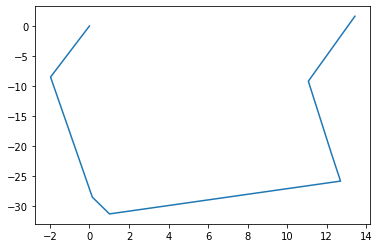

In [13]:
pathWayPointData = getPathWaypointData(pathFile)
pathWayPointData['dt'] = (pathWayPointData['timestamp'] - pathWayPointData.iloc[0,0]) / 1000.0
pathWaypointYaw = np.rad2deg(np.arctan2(np.diff(pathWayPointData.y), np.diff(pathWayPointData.x))) + 180.0

## path waypoints
waypoints = pathWayPointData.loc[:,['x', 'y']].values
localWayPoints = waypoints - waypoints[0]
plt.plot(localWayPoints[:,0], localWayPoints[:,1]);
plt.show()

## path IMU data

In [86]:
pathImuData = imuData[imuData.path == pathFile]
print(pathImuData.shape)

## pathImuData.loc[:,['acc_x', 'acc_y', 'acc_z']].describe()
## pathImuData.loc[:,['gyro_x', 'gyro_y', 'gyro_z']].describe()

(4612, 14)


In [87]:
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian
I = np.eye(9)

g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

In [120]:
var_imu_f = 0.1
var_imu_w = 0.05
subsample_size = 1

In [121]:
## timestamp
t = ((pathImuData.timestamp.values - pathImuData.timestamp[0]) / 1000.0)[::subsample_size]
## acc, gyro input
imu_f = avgValues(pathImuData.loc[:,['acc_x', 'acc_y', 'acc_z']].values, subsample_size)
imu_w = avgValues(pathImuData.loc[:,['gyro_x', 'gyro_y', 'gyro_z']].values, subsample_size)

## quaternion data
q0_w =math.sqrt(1 - (pathImuData['ahrs_q1'][0]** 2 +\
                     pathImuData['ahrs_q2'][0]** 2 +\
                     pathImuData['ahrs_q3'][0]**2))
q0 = np.array([q0_w, pathImuData['ahrs_q1'][0], pathImuData['ahrs_q2'][0], pathImuData['ahrs_q3'][0]])

In [122]:
## placeholders for estimates
p_est = np.zeros([imu_f.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.shape[0], 9, 9])  # covariance matrices at each timestep

## print shapes to verify
print(p_est.shape, v_est.shape, q_est.shape, p_cov.shape)

# Set initial values
p_est[0] = np.zeros(3)
v_est[0] = np.zeros(3)
q_est[0] = Quaternion(w=q0[0], x=q0[1], y=q0[2], z=q0[3]).to_numpy()
p_cov[0] = np.eye(9)  # covariance of estimate

(4612, 3) (4612, 3) (4612, 4) (4612, 9, 9)


In [123]:
F = np.eye(9)
Q = np.eye(6)

for k in range(1, imu_f.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = t[k] - t[k - 1]

    # 1. Update state with IMU inputs
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    p_est[k] = p_est[k-1] + v_est[k-1] * delta_t + (C_ns @ imu_f[k-1] + g) * delta_t**2 / 2
    v_est[k] = v_est[k-1] + (C_ns @ imu_f[k-1] + g) * delta_t
    q_est[k] = Quaternion(axis_angle=imu_w[k-1] * delta_t).quat_mult(q_est[k-1])

    # 1.1 Linearize Motion Model

    # 2. Propagate uncertainty
    F[:3, 3:6] = delta_t * np.eye(3)
    F[3:6, 6:] = -skew_symmetric(C_ns @ imu_f[k-1]) * delta_t
    Q[:3, :3] = var_imu_f * delta_t**2 * np.eye(3)
    Q[3:, 3:] = var_imu_w * delta_t**2 * np.eye(3)
    p_cov[k] = F @ p_cov[k-1] @ F.T + l_jac @ Q @ l_jac.T

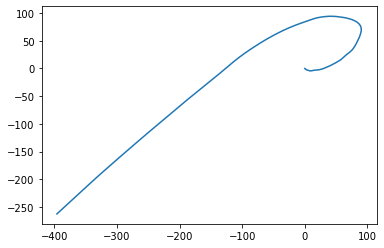

In [124]:
plt.plot(p_est[:,0], p_est[:,1])

```python
numPaths = 3
fig = make_subplots(rows=numPaths, cols=1)


for index in range(numPaths):
    pathFile = pathFilesList[20 + index] ## 10 + 
    ##print(pathFile)

    pathWayPointData = getPathWaypointData(pathFile)
    pathWayPointData['dt'] = (pathWayPointData['timestamp'] - pathWayPointData.iloc[0,0]) / 1000.0
    pathWaypointYaw = np.rad2deg(np.arctan2(np.diff(pathWayPointData.y), np.diff(pathWayPointData.x))) + 180.0

    ## path waypoints
    waypoints = pathWayPointData.loc[:,['x', 'y']].values
    localWayPoints = waypoints - waypoints[0]
    ## plt.plot(waypoints[:,0], waypoints[:,1])
    
    pathImuData = imuData[imuData.path == pathFile]
    pathImuData['dt'] = (pathImuData['timestamp'] - pathImuData['timestamp'][0]) / 1000.0
    pathImuData['yaw'] = pathImuData.apply(lambda row: getYawFromEuler(row['ahrs_q1'], row['ahrs_q2'], row['ahrs_q3']),axis=1)

    fig.add_trace(go.Scatter(x=pathWayPointData.dt, y=pathWaypointYaw, name =f'{index+1}_waypoint'), row=index+1, col=1)
    fig.add_trace(go.Scatter(x=pathImuData.dt, y=pathImuData.yaw, name =f'{index+1}_azimuth'), row=index+1, col=1)

fig.update_layout(height=600, width=600, title_text=f"{numPaths}_comparison")    
fig.show()
```

```python

wayPointData_train = getWayPointData_train()
buildingList = sorted(wayPointData_train.building.unique().tolist())
pathList     = sorted(wayPointData_train.path.unique().tolist())

output = []
wayPointBins = [0,5,10,20,84,110]
for building, buildingData in wayPointData_train.groupby(by='building'):
    for path, pathData in buildingData.groupby(by='path'):
        output.append([building, path, pathData.shape[0]])
        
output = pd.DataFrame(output, columns =['building', 'path', 'count'])  
output['countBin'] = pd.cut(output['count'], bins=wayPointBins)

## for building, buildingData in output.groupby(by='building'):
##    print(f"{building}, numPaths = {len(buildingData['path'].unique())}, minCount = {buildingData['count'].min()}, maxCount = {buildingData['count'].max()}")

for building, buildingData in output.groupby(by='building'):
    print('---------------------')
    print(building)
    print(buildingData['countBin'].value_counts(normalize=False))
```

In [ ]:
"""
#### rssi features is fixed, we can choose to use dt and freq features optionally
# Incase freq signal is not needed, use rssi and dt features alone    
# There are 5 columns for timestamp, y, pathNames values in csv, reamining are features
# total features = 3 * [rssi, dt, freq]
# hence unique wifi ids = totalFeatures / 3
"""
def getBuildingFeatures(buildingData, dataType):
    if dataType == 'train':
        buildingData = buildingData.iloc[:,1:-4].values.astype(np.float16)
    else:
        buildingData = buildingData.iloc[:,1:-1].values.astype(np.float16)
    
    numBssids = int(buildingData.shape[1] / 3)
    ## replace -999 with 99, 1000.0 with 50.0 and scale accordindly
    buildingData[buildingData == -999.0] = -99.0
    buildingData[buildingData == 1000.0] = 50.0
    buildingData[:,0:numBssids]              = buildingData[:,0:numBssids] / 100.0
    buildingData[:,numBssids: 2*numBssids]   = buildingData[:,numBssids: 2*numBssids] / 50.0
    buildingData[:,2*numBssids: 3*numBssids] = buildingData[:,2*numBssids: 3*numBssids] / 1000.0

    if CFG.USE_FREQ_FEATS == True:    
        ## use all features
        if CFG.USE_DT_FEATS == True:
            X = buildingData
        ## use rssi and freq features alone
        else:
            desiredFeatures = list(range(0, numBssids)) + list(range(2*numBssids, 3*numBssids))
            X = buildingData[:, desiredFeatures]
    else:
        ## use only rssi features alone
        if CFG.USE_DT_FEATS == True:
            X = buildingData[:,0:2*numBssids]
        ## use only rssi features alone
        else:
            X = buildingData[:,0:numBssids]
    return X

In [ ]:
def getBuildingData(buildingDataPath):
    # read building data 
    #### data = pd.read_pickle(buildingDataPath)
    with open(buildingDataPath, 'rb') as inputFile:
        data = pickle.load(inputFile)    
    
    # use fraction if needed
    if CFG.DATA_FRAC < 1:
        data = data.sample(frac=CFG.DATA_FRAC).reset_index(drop=True)

    # first column is timestamp
    timestamps = data.iloc[:,0].values   # np.expand_dims( , ,axis=1)
    
    # last column is pathFile name
    groups = data.iloc[:,-1].values
    
    # target values are last but 3 columns
    y = data.iloc[:,-4:-1].values
    X = getBuildingFeatures(data,'train')
    del data
    gc.collect()
    return timestamps,X,y,groups

In [ ]:
def getInputFeatureSize(featureFilesPath):
    sampleData = np.load(f"{npyWifiFeaturesDir}/{featureFilesPath[0]}")
    return len(sampleData)

In [ ]:
def competitionMetric(preds, targets):
    """ The metric used in this competition """
    # position error
    meanPosPredictionError = torch.mean(torch.sqrt(
                             torch.square(torch.subtract(preds[:,0], targets[:,0])) + 
                             torch.square(torch.subtract(preds[:,1], targets[:,1]))))
    # error in floor prediction
    meanFloorPredictionError = torch.mean(15 * torch.abs(preds[:,2] - targets[:,2]))
    return meanPosPredictionError, meanFloorPredictionError

In [ ]:
def getOptimizer(model : nn.Module):    
    if CFG.OPTIMIZER == 'Adam':
        optimizer = optim.Adam(model.parameters(), weight_decay=CFG.WEIGHT_DECAY, lr=CFG.MAX_LR)
    else:
        optimizer = optim.SGD(model.parameters(), weight_decay=CFG.WEIGHT_DECAY, lr=CFG.MAX_LR, momentum=0.9)
    return optimizer

In [ ]:
def getScheduler(optimizer, dataloader_train):
    if CFG.SCHEDULER == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr= CFG.MAX_LR, epochs = CFG.N_EPOCHS, 
                          steps_per_epoch = len(dataloader_train), pct_start=0.25, div_factor=10, anneal_strategy='cos')
    elif CFG.SCHEDULER == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=CFG.T_MULT, eta_min=CFG.MIN_LR, last_epoch=-1)
    elif CFG.SCHEDULER == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_MAX * len(dataloader_train), eta_min=CFG.MIN_LR, last_epoch=-1)
    else:
        scheduler = None
    return scheduler

In [ ]:
def getDataLoader(dataset, datasetType : str):
    if datasetType == 'train':
        batchSize = CFG.TRAIN_BATCH_SIZE
        shuffleDataset = True
    else:
        batchSize = CFG.TEST_BATCH_SIZE
        shuffleDataset = False
    
    dataLoader = DataLoader(dataset, batch_size= batchSize, shuffle=shuffleDataset,
                            num_workers=CFG.NUM_WORKERS, pin_memory=False, drop_last=False)
    return dataLoader

In [ ]:
def plotTrainingResults(resultsDf, buildingName):
    # subplot to plot
    fig = make_subplots(rows=1, cols=1)
    colors = [ ('#d32f2f', '#ef5350'), ('#303f9f', '#5c6bc0'), ('#00796b', '#26a69a'),
                ('#fbc02d', '#ffeb3b'), ('#5d4037', '#8d6e63')]

    # find number of folds input df
    numberOfFolds = resultsDf['fold'].nunique()
    
    # iterate through folds and plot
    for i in range(numberOfFolds):
        data = resultsDf[resultsDf['fold'] == i]
        fig.add_trace(go.Scatter(x=data['epoch'].values, y=data['trainPosLoss'].values,
                                mode='lines', visible='legendonly' if i > 0 else True,
                                line=dict(color=colors[i][0], width=2),
                                name='{}-trainPossLoss-Fold{}'.format(buildingName, i)),row=1, col=1)

        fig.add_trace(go.Scatter(x=data['epoch'], y=data['valPosLoss'].values,
                                 mode='lines+markers', visible='legendonly' if i > 0 else True,
                                 line=dict(color=colors[i][1], width=2),
                                 name='{}-valPosLoss-Fold{}'.format(buildingName,i)),row=1, col=1)
    fig.show()

## Dataset class

In [ ]:
class wiFiFeaturesDataset(Dataset):
    def __init__(self, timeStamps, X_data, y_data, groups):
        self.timeStamps = timeStamps 
        self.X_data = X_data
        self.y_data = y_data
        self.groups = groups
        
    def __getitem__(self, index):
        x  = torch.from_numpy(self.X_data[index].astype(np.float32))
        y  = torch.from_numpy(self.y_data[index].astype(np.float32))
        ts = self.timeStamps[index].astype(np.int64)
        group = self.groups[index]
        return ts,x,y,group
    
    def __len__ (self):
        return len(self.X_data)

In [ ]:
class wiFiFeaturesDataset_test(Dataset):
    def __init__(self, timeStamps, X_data, groups):
        self.timeStamps = timeStamps 
        self.X_data = X_data
        self.groups = groups
        
    def __getitem__(self, index):
        x  = torch.from_numpy(self.X_data[index].astype(np.float32))
        ts = self.timeStamps[index].astype(np.int64)
        group = self.groups[index]
        return ts,x,group
    
    def __len__ (self):
        return len(self.X_data)

## MLP Model class

In [ ]:
class wiFiFeaturesMLPModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.lin1 = nn.Linear(in_features=n_input, out_features=512)
        self.lin2 = nn.Linear(in_features=512,     out_features=32)
        self.lin3 = nn.Linear(in_features=32,      out_features=n_output)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(32)
        self.drops = nn.Dropout(0.3)        

    def forward(self, x):
        numBatches = x.shape[0]
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        
        ## batchnorm doesnt work for batchsize of 1
        if numBatches > 1:
            x = self.bn1(x)
            x = F.relu(self.lin2(x))
            x = self.drops(x)
            x = self.bn2(x)
            x = self.lin3(x)
        else:
            x = F.relu(self.lin2(x))
            x = self.drops(x)
            x = self.lin3(x)
        return x

## CNN WiFi features Model

In [ ]:
class CNNWiFiFeaturesModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.numBssids = int(n_input/3)
        self.conv1 = nn.Conv2d(1, 16, (3,64), stride=8)
        self.conv2 = nn.Conv2d(1,32, (3,64), stride=4)
        self.drops = nn.Dropout(p=0.3)
        self.fc_inputSize = self.getFC_InputSize(self.numBssids, [16,32])
        self.bn1 = nn.BatchNorm1d(self.fc_inputSize)        
        self.fc1 = nn.Linear(self.fc_inputSize, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16,n_output)
        
    def getConvOutputSize(self, h_in, w_in, kernel_height, kernel_width, paddSize, stride):
        h_out = int((h_in + 2*paddSize - kernel_height) / stride) + 1
        w_out = int((w_in + 2*paddSize - kernel_width)  / stride) + 1
        return (h_out,w_out)        
        
    def getFC_InputSize(self, numFeatures, filtersList):
        conv1_outputSize = self.getConvOutputSize(3,numFeatures, 3,64,0,8)
        conv2_outputSize = self.getConvOutputSize(filtersList[0], conv1_outputSize[1], 3,64,0,4)
        fc_inputSize = conv2_outputSize[0] * conv2_outputSize[1]
        return fc_inputSize

    def forward(self, x):
        numBatches = x.shape[0]
        x = x.view(numBatches,1,3,-1)        
        
        ## first conv layer
        x = F.relu(self.conv1(x))
        
        ## second conv layer
        x = x.view(numBatches, 1, 16, -1)
        x = F.relu(self.conv2(x))

        ## max pooling across channels, then dropout on features 
        x = torch.mean(x,1)
        x = x.view(numBatches,-1)
        ## x = self.drops(x)
        ## print(x.shape)
        
        ## fc layer starts
        ## batchnorm doesnt work for batchsize of 1
        if numBatches > 1:   
            x = self.bn1(x)
            x = F.relu(self.fc1(x))
            x = self.drops(x)
            x = self.bn2(x)
            x = F.relu(self.fc2(x))
            x = self.bn3(x)
            x = self.fc3(x)
        else:
            x = F.relu(self.fc1(x))
            x = self.drops(x)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x    

In [ ]:
class CNNWiFiFeaturesModel_variant2(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.numBssids = int(n_input/3)

        ## CNN layer definitions
        self.conv1 = nn.Conv2d(1,16,(3,64),stride=2)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.maxPool1 = nn.MaxPool2d(3, stride=2)  
        self.conv2 = nn.Conv2d(1,16,(3,64),stride=2)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,(3,64),stride=2)
        self.conv3_bn = nn.BatchNorm2d(32)

        ## calculate the fc layer input size
        self.fc_inputSize = self.getFC_InputSize(self.numBssids, [16,16,32])
        
        ## dropout for regularisation
        self.drops = nn.Dropout(p=0.3)
        
        ## fc layers definition
        self.fc1 = nn.Linear(self.fc_inputSize, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, n_output)
        
        
    def getConvOutputSize(self, h_in, w_in, kernel_height, kernel_width, paddSize, stride):
        h_out = int((h_in + 2*paddSize - kernel_height) / stride) + 1
        w_out = int((w_in + 2*paddSize - kernel_width)  / stride) + 1
        return (h_out,w_out)        
        
    def getFC_InputSize(self, numFeatures, filtersList):
        conv1_outputSize = self.getConvOutputSize(3,numFeatures,3,64,0,2)
        inputHead_outputSize = self.getConvOutputSize(filtersList[0], conv1_outputSize[1], 3,3,0,2)
        conv2_outputSize = self.getConvOutputSize(inputHead_outputSize[0], inputHead_outputSize[1], 3,64,0,2)
        featureExtractor_outputSize = self.getConvOutputSize(conv2_outputSize[0], conv2_outputSize[1],3,63,0,2)
        fc_inputSize = featureExtractor_outputSize[0] * featureExtractor_outputSize[1]
        return fc_inputSize

    def forward(self, x):
        numBatches = x.shape[0]
        x = x.view(numBatches,1,3,-1)        
        
        ## first conv layer
        x = F.relu(self.conv1_bn(self.conv1(x)).view(numBatches, 1, 16, -1))
        
        ## inputHead + featureExtractor conv layers
        x = self.maxPool1(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.conv3_bn(self.conv3(x))

        ## avg pooling across channels, then dropout on features 
        x = torch.mean(x,1)
        x = x.view(numBatches,-1)
        ## x = self.drops(x)
        ## print(x.shape)
        
        """
        fc layer starts
        ---------------
        Conv/fc -> batchnorm -> relu activation -> dropout -> conv/fc
        ---------------
        batchnorm doesnt work for batchsize of 1
        """
        if numBatches > 1:
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.drops(x)
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.fc3(x)
        else:
            x = F.relu(self.fc1(x))
            x = self.drops(x)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x    

## Lr range finder

In [ ]:
def plot_lr_finder_results(lr_finder): 
    # Create subplot grid
    fig = make_subplots(rows=1, cols=2)
    # layout ={'title': 'Lr_finder_result'}
    
    # Create a line (trace) for the lr vs loss, gradient of loss
    trace0 = go.Scatter(x=lr_finder['log_lr'], y=lr_finder['smooth_loss'],name='log_lr vs smooth_loss')
    trace1 = go.Scatter(x=lr_finder['log_lr'], y=lr_finder['grad_loss'],name='log_lr vs loss gradient')

    # Add subplot trace & assign to each grid
    fig.add_trace(trace0, row=1, col=1);
    fig.add_trace(trace1, row=1, col=2);
    iplot(fig, show_link=False)
    #fig.write_html(CFG.MODEL_NAME + '_lr_find.html');

In [ ]:
def find_lr(model, optimizer, data_loader, init_value = 1e-8, final_value=100.0, beta = 0.98, num_batches = 200):
    assert(num_batches > 0)
    mult = (final_value / init_value) ** (1/num_batches)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    batch_num = 0
    avg_loss = 0.0
    best_loss = 0.0
    smooth_losses = []
    raw_losses = []
    log_lrs = []
    dataloader_it = iter(data_loader)
    progress_bar = tqdm(range(num_batches))                
        
    for idx in progress_bar:
        batch_num += 1
        try:
            _, inputs, targets = next(dataloader_it)
            #print(images.shape)
        except:
            dataloader_it = iter(data_loader)
            _, inputs, targets = next(dataloader_it)

        # Move input and label tensors to the default device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # handle exception in criterion
        try:
            # Forward pass
            y_preds = model(inputs)
            posLoss, floorLoss = criterion(y_preds, targets)
            loss = posLoss + floorLoss
        except:
            if len(smooth_losses) > 1:
                grad_loss = np.gradient(smooth_losses)
            else:
                grad_loss = 0.0
            lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                                 'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
            return lr_finder_results 
                    
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 50 * best_loss:
            if len(smooth_losses) > 1:
                grad_loss = np.gradient(smooth_losses)
            else:
                grad_loss = 0.0
            lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                                 'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
            return lr_finder_results
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        #Store the values
        raw_losses.append(loss.item())
        smooth_losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print info
        progress_bar.set_description(f"loss:{loss.item()},smoothLoss: {smoothed_loss},lr:{lr}")

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    
    grad_loss = np.gradient(smooth_losses)
    lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                         'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
    return lr_finder_results

In [ ]:
if CFG.LR_FIND == True:
    # create dataset instance
    tempTs, tempX, tempY,_ = getBuildingData(buildingCsvPath=buildingsList[0])
    tempX = stdScaler.fit_transform(tempX)
    tempTrainDataset = wiFiFeaturesDataset(tempTs, tempX, tempY)
    tempTrainDataloader = DataLoader(tempTrainDataset, batch_size= CFG.TRAIN_BATCH_SIZE, shuffle=True,
                          num_workers=CFG.NUM_WORKERS, pin_memory=False, drop_last=False)
    
    # create model instance   
    model = wiFiFeaturesMLPModel(n_input=tempX.shape[1], n_output=3)
    model.to(device);
    
    # optimizer function, lr schedulers and loss function
    optimizer = getOptimizer(model)
    lrFinderResults = find_lr(model, optimizer, tempTrainDataloader)
    plot_lr_finder_results(lrFinderResults)
    del tempX, tempY, tempTrainDataset, tempTrainDataloader, model, optimizer

## Train & Validate helper functions

In [ ]:
def validateModel(model, validationDataloader):
    # placeholders to store output
    val_ts = []
    val_preds = []
    val_targets = []
    val_groups = []

    # set model to Validate mode
    model.eval()
    dataLoaderIterator = iter(validationDataloader)

    for idx in range(len(validationDataloader)):
        try:
            ts, inputs, targets, valGroups = next(dataLoaderIterator)
        except StopIteration:
            dataLoaderIterator = iter(validationDataloader)
            ts, inputs, targets, valGroups = next(dataLoaderIterator)

        inputs = inputs.to(device)
        targets = targets.to(device) 

        # forward prediction
        with torch.no_grad():    
            y_preds = model(inputs)

        # store predictions and targets to compute metrics later
        val_ts.append(ts)
        val_preds.append(y_preds)
        val_targets.append(targets)
        val_groups.append(valGroups)

    # concatenate to get as 1 2d array and find total loss  
    val_preds = torch.cat(val_preds, 0)
    val_targets = torch.cat(val_targets, 0)
    valPosLoss, valFloorLoss = criterion(val_preds, val_targets)
    valScore = valPosLoss + valFloorLoss

    # np array concatenation
    val_ts = np.concatenate(val_ts, axis=0)
    val_groups = np.concatenate(val_groups, axis=0)
    
    # store results
    validationResults = {'valPosLoss': valPosLoss.item() , 'valFloorLoss': valFloorLoss.item(),\
                         'val_ts': val_ts, 'val_groups': val_groups,
                         'val_preds'  :val_preds.cpu().data.numpy(), 
                         'val_targets':val_targets.cpu().data.numpy(),
                         }
    return validationResults

In [ ]:
def trainValidateOneFold(buildingName, i_fold, model, optimizer, scheduler, dataloader_train, dataloader_valid):
    trainFoldResults = []
    bestValScore = np.inf
    bestEpoch = 0

    for epoch in range(CFG.N_EPOCHS):
        #print('Epoch {}/{}'.format(epoch + 1, CFG.N_EPOCHS))
        model.train()
        trainPosLoss = 0.0
        trainFloorLoss = 0.0

        # training iterator
        tr_iterator = iter(dataloader_train)

        for idx in range(len(dataloader_train)):
            try:
                _, inputs, targets, _ = next(tr_iterator)
            except StopIteration:
                tr_iterator = iter(dataloader_train)
                _, inputs, targets, _ = next(tr_iterator)

            inputs = inputs.to(device)
            targets = targets.to(device)  

            # builtin package to handle automatic mixed precision
            with autocast():
                # Forward pass
                y_preds = model(inputs)   
                posLoss, floorLoss = criterion(y_preds, targets)
                loss = posLoss + floorLoss

                # Backward pass
                scaler.scale(loss).backward()        
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 

                # log the necessary losses
                trainPosLoss   += posLoss.item()
                trainFloorLoss += floorLoss.item()

                if scheduler is not None: 
                    if CFG.SCHEDULER == 'CosineAnnealingWarmRestarts':
                        scheduler.step(epoch + idx / len(dataloader_train)) 
                    # onecyle lr scheduler / CosineAnnealingLR scheduler
                    else:
                        scheduler.step()
                    
        # Validate
        foldValidationResults = validateModel(model, dataloader_valid)
         
        # store results
        trainFoldResults.append({ 'fold': i_fold, 'epoch': epoch, 
                                  'trainPosLoss': trainPosLoss / len(dataloader_train), 
                                  'trainFloorLoss': trainFloorLoss / len(dataloader_train), 
                                  'valPosLoss'  : foldValidationResults['valPosLoss'] , 
                                  'valFloorLoss': foldValidationResults['valFloorLoss']})
        
        valScore = foldValidationResults['valPosLoss'] # + foldVal['valFloorLoss']
        # save best models        
        if(valScore < bestValScore):
            # reset variables
            bestValScore = valScore
            bestEpoch = epoch

            # save model weights
            torch.save({'model': model.state_dict(), 'val_ts' : foldValidationResults['val_ts'], 
                        'val_preds':foldValidationResults['val_preds'], 
                        'val_targets':foldValidationResults['val_targets'],
                        'val_groups' : foldValidationResults['val_groups']}, 
                        f"{modelOutputDir}/{buildingName}_{CFG.MODEL_NAME}_fold{i_fold}_best.pth")

    print(f"For Fold {i_fold}, Best position validation score of {bestValScore} was got at epoch {bestEpoch}") 
    return trainFoldResults

In [ ]:
def trainValidateOneBuilding(buildingDataPath, modelToFit):
    # placeholder to store results
    buildingTrainResults = []
    
    buildingName = getBuildingName(buildingDataPath)
    print(f"Processing data for building - {buildingName}")
    timestamps, X, y, groups = getBuildingData(buildingDataPath)
    print(f"Building Data shapes : {timestamps.shape, X.shape, y.shape, groups.shape}")

    for i_fold, (trainIndex, validIndex) in enumerate(folds.split(X=X, y=y[:,0],groups=groups)):
        if i_fold in CFG.FOLD_TO_TRAIN:
            ## print("Fold {}/{}".format(i_fold + 1, CFG.N_FOLDS))
            
            # splitting into train and validataion sets
            trainTimeStamps, X_train, y_train, trainGroups = timestamps[trainIndex], X[trainIndex], y[trainIndex], groups[trainIndex]
            validTimeStamps, X_valid, y_valid, validGroups = timestamps[validIndex], X[validIndex], y[validIndex], groups[validIndex] 
                        
            # create torch Datasets and Dataloader for each fold's train and validation data
            dataset_train = wiFiFeaturesDataset(trainTimeStamps, X_train, y_train, trainGroups)
            dataset_valid = wiFiFeaturesDataset(validTimeStamps, X_valid, y_valid, validGroups)            
            dataloader_train = getDataLoader(dataset_train, datasetType= 'train')
            dataloader_valid = getDataLoader(dataset_valid, datasetType= 'valid')
            
            # supervised model instance and move to compute device
            model = modelToFit(n_input=X.shape[1], n_output=3)
            model.to(device);
            ### print(f"there are {find_no_of_trainable_params(model)} params in model")

            # optimizer function, lr schedulers and loss function
            optimizer = getOptimizer(model)
            scheduler = getScheduler(optimizer, dataloader_train)
            # print(f"optimizer={optimizer}, scheduler={scheduler}, loss_fn={criterion}")

            # train and validate single fold
            foldResults = trainValidateOneFold(buildingName, i_fold, model, optimizer, scheduler,dataloader_train, dataloader_valid)
            buildingTrainResults = buildingTrainResults + foldResults
            
            del trainTimeStamps, X_train, y_train, trainGroups
            del validTimeStamps, X_valid, y_valid, validGroups
            del dataloader_train, dataloader_valid, model, optimizer, scheduler
            gc.collect()
    
    del timestamps, X, y, groups
    gc.collect()
    
    buildingTrainResults = pd.DataFrame(buildingTrainResults)
    buildingTrainResults['valTotalLoss'] = buildingTrainResults['valPosLoss'] + buildingTrainResults['valFloorLoss']
    buildingTrainResults['trainTotalLoss'] = buildingTrainResults['trainPosLoss'] + buildingTrainResults['trainFloorLoss']
    return buildingTrainResults

In [ ]:
def getFoldBestResultsDf(trainResults):
    bestResults = []
    numFolds = trainResults['fold'].nunique()
    
    for fold in range(numFolds):
        foldDf = trainResults[trainResults['fold']== fold]
        bestResults.append(foldDf.iloc[np.argmin(foldDf['valTotalLoss'].values),:])
    
    bestResults =pd.DataFrame(bestResults)
    valPosLossBest = bestResults['valPosLoss'].values
    print(f"Best valPosLoss for all folds = {valPosLossBest}")
    print(f"Mean, std ={valPosLossBest.mean()}, {valPosLossBest.std()}")
    return bestResults

## Generate OOF function

In [ ]:
def generateOOF(modelSaveDir:str, buildingName:str, modelName:str):
    oof_ts = []
    oof_preds = []
    oof_targets = []
    oof_groups = []
    oof_folds = []

    modelPaths = sorted(glob.glob(f"{modelSaveDir}/{buildingName}_{modelName}_fold*.pth"))

    for fold in range(len(modelPaths)):
        # load building-model-fold checkpoint
        checkPoint = torch.load(modelPaths[fold], map_location=torch.device(device))
        numRows = len(checkPoint['val_ts'])

        oof_ts.append(checkPoint['val_ts'])
        oof_preds.append(checkPoint['val_preds'])
        oof_targets.append(checkPoint['val_targets'])
        oof_groups.append(checkPoint['val_groups'])
        oof_folds.append([fold] * numRows)
    
    oof_ts = np.concatenate(oof_ts,axis=0)
    oof_preds = np.concatenate(oof_preds,axis=0)
    oof_targets = np.concatenate(oof_targets,axis=0)
    oof_groups = np.concatenate(oof_groups,axis=0)
    oof_folds = np.concatenate(oof_folds,axis=0)
    
    #print(oof_ts.shape, oof_preds.shape, oof_targets.shape, oof_groups.shape, oof_folds.shape)
    oof_df = pd.DataFrame({'timestamp' : oof_ts, 'x_preds': oof_preds[:,0], 'y_preds': oof_preds[:,1],
                       'floor_preds': oof_preds[:,2], 'x_tgt': oof_targets[:,0], 'y_tgt': oof_targets[:,1],
                       'floor_tgt': oof_targets[:,2], 'path' : oof_groups, 'fold' : oof_folds
                      })
    print(f"OOF prediction for {buildingName} site generated")
    return oof_df

## Test set prediction function

In [ ]:
def generateWiFiSubmission(modelToFit, modelSaveDir:str, buildingName:str, modelName:str):
    modelPaths = sorted(glob.glob(f"{modelSaveDir}/{buildingName}_{modelName}_fold*.pth"))
    buildingTestData = f"{wifiFeaturesDir_test}/{buildingName}_test.pickle"
    with open(buildingTestData, 'rb') as inputFile:
        testData = pickle.load(inputFile)    
    
    test_ts = []
    test_fold = []
    test_preds = []
    test_groups = []

    for fold in range(CFG.N_FOLDS):
        ## print(f"Fold {fold} processing")
        #print(f"Before stdscaler : testX mean = {testX.mean()}, testData std = {testX.std()}")
        testGroups = testData.iloc[:,-1].values    
        testTimestamps = testData.iloc[:,0].values        
        testX = getBuildingFeatures(testData, 'test')  
        
        checkPoint = torch.load(modelPaths[fold], map_location=torch.device(device))
        model = modelToFit(n_input=testX.shape[1], n_output=3)
        model.to(device);
        model.load_state_dict(checkPoint['model'])

        # set model to Validate mode
        model.eval()
        ## test Dataset and data loaders
        testDataset = wiFiFeaturesDataset_test(testTimestamps, testX, testGroups)
        testDataloader = getDataLoader(testDataset, datasetType= 'test')

        dataLoaderIterator = iter(testDataloader)
        for idx in range(len(testDataloader)):
            try:
                ts, inputs, testGroups = next(dataLoaderIterator)
            except StopIteration:
                dataLoaderIterator = iter(testDataloader)
                ts, inputs, testGroups = next(dataLoaderIterator)

            inputs = inputs.to(device)
            # forward prediction
            with torch.no_grad():    
                y_preds = model(inputs)

            # store predictions and targets to compute metrics later
            test_ts.append(ts)
            test_preds.append(y_preds)
            test_groups.append(testGroups)
        
        test_fold.append([fold] * len(testX))
        del testDataloader
        ## torch.cuda.empty_cache()
        gc.collect()
        
    # concatenate to get as 1 2d array 
    test_preds = torch.cat(test_preds, 0).cpu().data.numpy() 
    test_ts = np.concatenate(test_ts, axis=0)
    test_fold = np.concatenate(test_fold, axis=0)
    test_groups = np.concatenate(test_groups, axis=0)
    subm_wifi_df = pd.DataFrame({'timestamp' : test_ts, 'x_preds': test_preds[:,0], 'y_preds': test_preds[:,1],
                                 'floor_preds': test_preds[:,2], 'path' : test_groups, 'fold' : test_fold})
    subm_wifi_df.to_pickle(f"{buildingName}_wifi_subm.pickle")  
    print(f"Test data prediction for {buildingName} site generated")

## Compute Device as CPU or GPU

In [ ]:
## Device as cpu or tpu
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')
print(device)

## Preprocessing classes

In [ ]:
# for cv
folds = GroupKFold(n_splits=CFG.N_FOLDS)

# scaler to handle AMP
scaler = GradScaler()   

criterion = competitionMetric
modelToFit = CNNWiFiFeaturesModel   ## CNNWiFiFeaturesModel_variant2

## Training & Validation main function

In [ ]:
%%time
if CFG.TRAIN == True:
    
    buildingPathList_train = sorted(glob.glob(f"{wifiFeaturesDir_train}/*.pickle"))
    buildingPathList_train = buildingPathList_train[CFG.BUILDING_SITES_RANGE[0]: CFG.BUILDING_SITES_RANGE[1]]
    print(f"{len(buildingPathList_train)} sites are to be trained")
    ## print(buildingPathList_train)

    for buildingPath_train in buildingPathList_train:
        
        print('----------------------------------')
        ## get building name
        buildingName = getBuildingName(buildingPath_train)
        
        ## train and validate for building data
        buildingTrainResults = trainValidateOneBuilding(buildingPath_train, modelToFit)
        bestResults = getFoldBestResultsDf(buildingTrainResults)
        
        ## generate OOF prediction for building-model combination
        buildingOOF = generateOOF(modelOutputDir, buildingName, CFG.MODEL_NAME)
        
        ## prediction for test data too
        generateWiFiSubmission(modelToFit, modelOutputDir, buildingName, CFG.MODEL_NAME)

        ## save results to file
        buildingOOF.to_pickle(f"{modelOutputDir}/{buildingName}_{CFG.MODEL_NAME}_OOF.pickle")
        bestResults.to_pickle(f"{modelOutputDir}/{buildingName}_{CFG.MODEL_NAME}_bestResults.pickle")
        buildingTrainResults.to_pickle(f"{modelOutputDir}/{buildingName}_{CFG.MODEL_NAME}_trainResults.pickle")
        
        ## plot building results
        plotTrainingResults(buildingTrainResults, buildingName)

In [ ]:
bestResults

```python
buildingPathList_train = sorted(glob.glob(f"{wifiFeaturesDir_train}/*.pickle"))
buildingPathList_test = sorted(glob.glob(f"{wifiFeaturesDir_test}/*.pickle"))

for idx in range(len(buildingPathList_train)):
    print('-----------------------------')
    trainFilePath = buildingPathList_train[idx]
    testFilePath  = buildingPathList_test[idx]
    print(f"{idx}. {getBuildingName(trainFilePath)}")
    with open(trainFilePath, 'rb') as inputTrainFile:
        trainData = pickle.load(inputTrainFile)
    with open(testFilePath, 'rb') as inputTestFile:
        testData = pickle.load(inputTestFile)
    
    with pd.option_context('display.max_rows', 1, 'display.max_columns', 12,
                           'display.width', 500, 'display.precision', 3,
                           'display.colheader_justify', 'left'):
        display(trainData)
        display(testData)
```        